## Demo Notebook for Accessing the Wind Integration National Dataset (WIND) Toolkit on Azure

The WIND Toolkit is available on Microsoft Azure's Planetary Computer in HDF5 format. Kerchunk reference files are provided to facilitate speedy access. This notebook demonstrates how to access and use this data. 

First, specify which data subset and resolution you are interested in.

datasubset and resolution options:

| datasubset | resolution |
| --- | --- |
| Great_Lakes | hourly, 5min |
| Hawaii | hourly, 5min |
| bangladesh | hourly |
| Mid_Atlantic | hourly, 5min |
| NW_Pacific | hourly, 5min |
| Offshore_CA | hourly, 5min |
| canada/v1.0.0 | hourly, 5min* |
| canada/v1.0.0bc | hourly, 5min |
| canada/v1.1.0 | hourly, 5min |
| canada/v1.1.0bc | hourly, 5min |
| central_asia | 15min* |
| conus/v1.0.0 | hourly, 5min* |
| conus/v1.1.0 | hourly, 5min |
| eastern_wind | 10min* |
| gulf_of_mexico | hourly, 5min* |
| india | 5min* |
| North_Atlantic | hourly, 5min |
| mexico/v1.0.0 | hourly, 5min* |
| mexico/v1.1.0 | hourly, 5min |
| philippines | hourly |
| philippines_tmy | hourly* |
| pr100 | hourly, 5min |
| seasiawind/v1 | 15min* |
| seasiawind/v2 | 15min* |
| south_atlantic | hourly, 5min* |
| vietnam | hourly* |
| western_wind | 10min* |
| wtk-us | hourly* |

\* data migration still in progress

In [1]:
datasubset = 'south_atlantic'
resolution = 'hourly'

Next, we load the relevant kerchunk reference file from the main wtk directory of the oedi container.

In [2]:
import planetary_computer
import ujson

fs = planetary_computer.get_adlfs_filesystem('nrel', 'oedi')
with fs.open(f'oedi/wtk/{datasubset}/kerchunk_{resolution}_ref.json', 'rb') as ref_file:
    ref = ujson.load(ref_file)

Now we can use the references to create an xarray dataset object. Note that no data is actually downloaded until you query this object. Also, the planetary_computer token expires after about an hour and you will need to rerun this cell to regain access to the dataset.

In [3]:
import xarray as xr

token = planetary_computer.sas.get_token('nrel', 'oedi').token
ds = xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": ref,
            "remote_protocol": "abfs",
            "remote_options": {'account_name': 'nrel', "credential": token}
        },
        "consolidated": False,
    }
)
ds

<xarray.Dataset>
Dimensions:                       (time_index: 184104, gid: 328443)
Coordinates:
  * gid                           (gid) float64 0.0 1.0 ... 3.284e+05 3.284e+05
  * time_index                    (time_index) datetime64[ns] 2000-01-01 ... ...
Data variables: (12/75)
    boundary_layer_height         (time_index, gid) float32 ...
    country                       (gid) object ...
    county                        (gid) object ...
    elevation                     (gid) float32 ...
    friction_velocity_2m          (time_index, gid) float32 ...
    inversemoninobukhovlength_2m  (time_index, gid) float32 ...
    ...                            ...
    windspeed_300m                (time_index, gid) float32 ...
    windspeed_400m                (time_index, gid) float32 ...
    windspeed_40m                 (time_index, gid) float32 ...
    windspeed_500m                (time_index, gid) float32 ...
    windspeed_60m                 (time_index, gid) float32 ...
    windspeed_80m                 (time_index, gid) float32 ...
Attributes:
    identical_dims:  ['gid', 'latitude', 'longitude', 'country', 'state', 'co...

The output in the cell above lets you browse the schema for the data set. Let's pick one of the variables and a snapshot in time and generate a map.

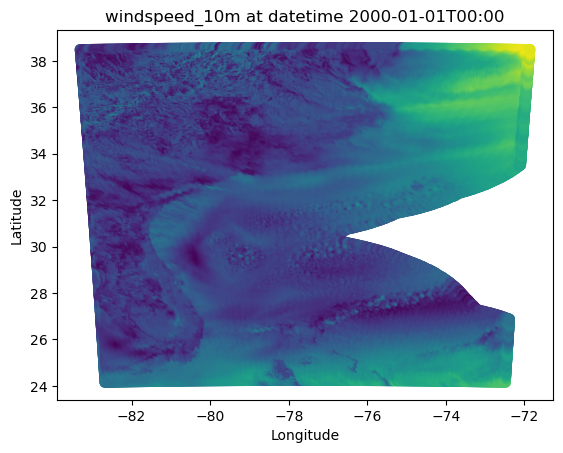

In [4]:
import matplotlib.pyplot as plt
import numpy as np

var = 'windspeed_10m'

time_indx = 0
dt = ds['time_index'][time_indx].values
dt = np.datetime_as_string(dt,unit='m')
lon = ds['longitude'][:].values
lat = ds['latitude'][:].values
data = ds[var][time_indx,:].values

plt.scatter(lon, lat, c=data)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{var} at datetime {dt}')
plt.show()

You can also choose a particular location and view a time series graph.

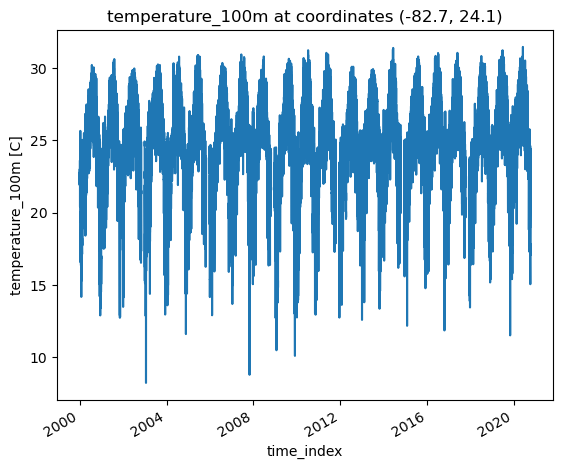

In [5]:
gid = 0
var = 'temperature_100m'
lon = ds['longitude'][gid].values
lat = ds['latitude'][gid].values
ds[var][:, gid].plot()
plt.title(f'{var} at coordinates ({lon:.1f}, {lat:.1f})')
plt.show()

Finally, we show how to find the location closest to a given set of coordinates and plot some data.

In [6]:
from math import radians
from sklearn.neighbors import BallTree
import numpy as np

my_coords = [-66, 17]  # Coordinates of interest
time_sel = '2017-07'    # Make sure your selection is in range for the data set selected!

my_coords_rad = [radians(my_coords[0]), radians(my_coords[1])]
all_coords_rad = np.array([[radians(lon), radians(lat)] for lon, lat in zip(ds['longitude'].values, ds['latitude'].values)])
tree = BallTree(all_coords_rad, metric='haversine')
my_gid = tree.query([my_coords_rad])[1][0][0]

var = 'windspeed_10m'
lon = ds['longitude'][my_gid].values
lat = ds['latitude'][my_gid].values
ds[var].sel(time_index='2017-07', gid=my_gid).plot()    # Time slice for July 2008
plt.title(f'{var} at coordinates ({lon:.1f}, {lat:.1f})')
plt.show()

ModuleNotFoundError: No module named 'sklearn'